In [1]:
# Data handling
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import load_npz, csr_matrix

# Model building
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
from pandas.plotting import parallel_coordinates

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# suppress all warnings to improve readability. NOT RECOMMENDED
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Convert entire matrix to Pandas DataFrame (sparse format)
sparse_matrix = load_npz("data_processed/sales_record.npz")
global_items = pd.read_csv("data_processed/global_items.csv").iloc[:, 0].tolist()
global_transactions = pd.read_csv("data_processed/global_transactions.csv").iloc[:, 0].tolist()
df = pd.DataFrame.sparse.from_spmatrix(
    sparse_matrix,
    index=global_transactions,  # Transaction IDs as rows
    columns=global_items        # Items as columns
)

df

,1/4 TOURNEVIS,100% FUN 5.39$,10FT MICRO TYPE C CHARG,10PI CABLE CHARG.SYNCH.8BROC.,11IN FLEXIBLE FUNNEL,12V FAN,16PO KNOKER,3MOUSQUETAIRE SA ROUSSE 473ML-C,3MOUSQUETAIRES LTM IPA 473ML-C,3PI FIRESTIK ANTENNA BLACK,...,ZIG ZAG ULTRAMINCE 1 1/4,ZIG-ZAG CONES BLANC 1 1/4,ZIG-ZAG CONES BLANC KS,ZIG-ZAG KS SLIM 32 FEUILLES,ZIPLOC SAC SANDWICH 40U,ZOA ENER. ZS FRAISE PAST.355ML (X),ZOA ENER. ZS ORANGE SAUV.355ML,ZOA ENERG.ZS PUNCH TROP.355ML,ZOA ENERG.ZS RAISIN GIVRE355ML,ZOOM LED MAGNIFIER
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
684030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
684036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
684042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns[df.columns.str.startswith("FDD")]


Index(['FDD BC 0.10', 'FDD EAU 0.10', 'FDD EAU 0.50', 'FDD GM 0.50'], dtype='object')

In [4]:
# beer and FDD
df = df.drop(columns=['Super','Reg.','BLEUE DRY 10.1% (1X740ML-C)', 'BUDWEISER (6X)473ML-C', 'LOTO VALIDEUSE','MACDONALD ORIG REG 20','FDD BC 0.10', 'FDD EAU 0.10', 'FDD EAU 0.50', 'FDD GM 0.50'])

In [5]:
# convert to binary
df_binary = (df > 0).astype(int)  # Convert non-zero values to 1

In [6]:
sum_df = df.sum(axis=0)
sum_df.astype(float).describe()

count      4524.000000
mean       1794.814014
std        5644.570540
min           2.000000
25%          48.000000
50%         414.000000
75%        1675.500000
max      193476.656250
dtype: float64

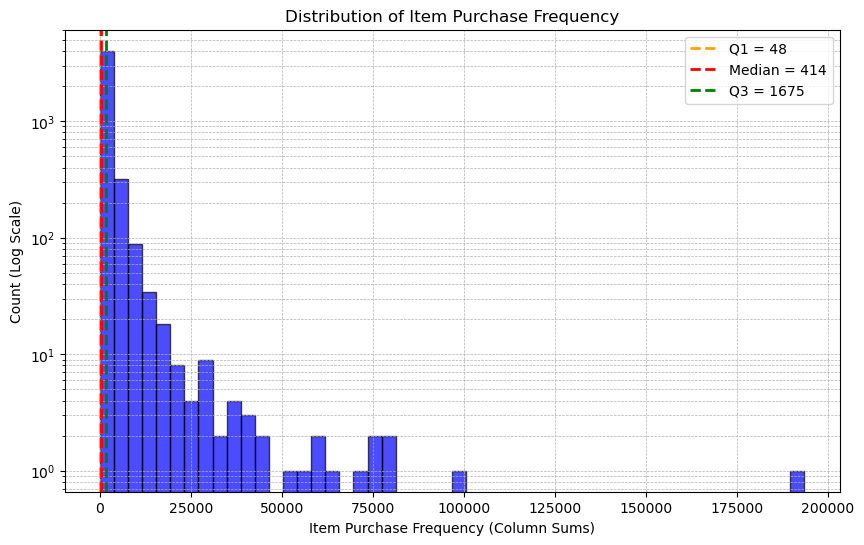

In [7]:
# Compute quartiles (Q1, Median, Q3)
Q1 = np.percentile(sum_df, 25)
Median = np.percentile(sum_df, 50)
Q3 = np.percentile(sum_df, 75)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sum_df, bins=50, alpha=0.7, color='blue', edgecolor='black', log=True)

# Add vertical lines for thresholds
plt.axvline(Q1, color='orange', linestyle='dashed', linewidth=2, label=f'Q1 = {int(Q1)}')
plt.axvline(Median, color='red', linestyle='dashed', linewidth=2, label=f'Median = {int(Median)}')
plt.axvline(Q3, color='green', linestyle='dashed', linewidth=2, label=f'Q3 = {int(Q3)}')

# Labels and title
plt.xlabel("Item Purchase Frequency (Column Sums)")
plt.ylabel("Count (Log Scale)")
plt.title("Distribution of Item Purchase Frequency")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()
del sum_df

In [8]:
df_shuffled = df_binary.sample(frac=1, random_state=42)

# Split into chunks
df_chunks = np.array_split(df_shuffled, 2)


In [9]:
del df,df_binary

In [10]:
frequent_itemsets_list = []

# Process each chunk separately to avoid memory overload
for i, chunk in enumerate(df_chunks):
    print(f"Processing chunk {i+1}/{2}...")
    
    # Convert to boolean to reduce memory usage
    chunk_bool = chunk.astype(bool)

    # Apply FP-Growth algorithm
    frequent_itemsets_chunk = fpgrowth(
        chunk_bool,
        min_support=0.01,
        use_colnames=True
    )
    
    # Store the results
    frequent_itemsets_list.append(frequent_itemsets_chunk)

# Combine all results
frequent_itemsets = pd.concat(frequent_itemsets_list, ignore_index=True)


Processing chunk 1/2...
Processing chunk 2/2...


In [11]:
### Generate rules
# Rules without any metric
rules = association_rules(frequent_itemsets, metric='support', min_threshold = 0.0)

In [12]:
frequent_itemsets

,support,itemsets
0,0.086209,(TSB MOYEN CAFE REGULIER)
1,0.032232,(BREUV.FROID FONTAINE 20OZ)
2,0.029907,(CSP DANOISE YOG.GREC CERISE)
3,0.010169,(CSP TORSADE CHOCOLAT)
4,0.063606,(RED BULL 250ML)
...,...,...
183,0.014430,(GATORADE BLEU COOL 710ML)
184,0.013512,(BEATRICE LAIT 2% 2L)
185,0.010069,(ESKA EAU DE SOURCE SPORT 1L)
186,0.013851,(RUIZ TORNADO PEPP.& FROMAGE)


In [13]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(TSB MOYEN CAFE REGULIER),(TSB PETIT CAFE REGULIER),0.087057,0.084073,0.010059,0.115543,1.374314,1.0,0.00274,1.035581,0.298337,0.06245,0.034359,0.117594
1,(TSB PETIT CAFE REGULIER),(TSB MOYEN CAFE REGULIER),0.084073,0.087057,0.010059,0.119644,1.374314,1.0,0.00274,1.037015,0.297365,0.06245,0.035694,0.117594


In [29]:
rules['lift'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: lift, dtype: object

In [30]:
# Prune rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.3)

In [31]:
print(rules['antecedents'])

Series([], Name: antecedents, dtype: object)


In [32]:
### Visualize rules
## 1. Parallel coordinate plot to look at the 'network'
# Create coordinates to be used in the plot
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0]) # Extract the first name of the list
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index

coords = rules[['antecedent','consequent','rule']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


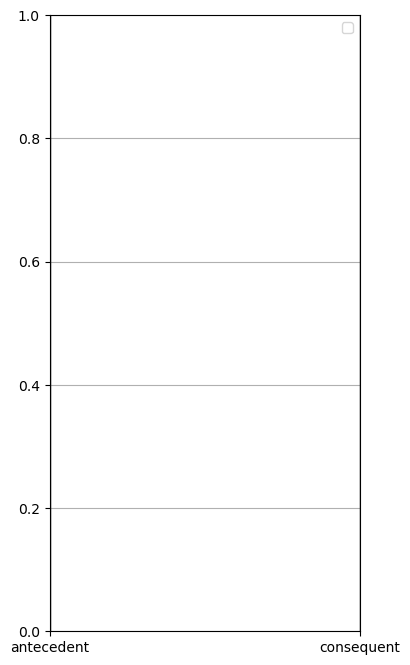

In [33]:
# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()

In [34]:
## 2. Heatmap to look at the intensity of each rule

# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform antecedent, consequent, and confidence columns into matrix
confidence_table = rules.pivot(index='consequents', columns='antecedents', values='confidence')

In [ ]:
# Generate heatmap
plt.figure(figsize=(10,6))
sns.heatmap(confidence_table, cmap = sns.cm.rocket_r)
plt.yticks(rotation=0)
plt.show()

In [40]:
import os

In [41]:
# save
# rules.to_csv(os.path.join(os.getcwd(), "data_processed", "rules.csv"), index=False)
frequent_itemsets.to_csv(os.path.join(os.getcwd(), "data_processed", "frequent_baskets.csv"), index=False)

In [43]:
import re
# extract wanted product sets
product = pd.read_csv('data_processed/frequent_baskets.csv')
pattern = r"'([^']+)'"
unique_products = set()

for item in product['itemsets'].unique():
    matches = re.findall(pattern, item)
    unique_products.update(matches)

print(unique_products)

{'CSP MUFFIN MORCEAUX CHOCOLAT', 'CSP CHOCOLATINE', 'CSP AVALANCHE CHOCOLAT', 'RED BULL SANS SUCRE 250ML', 'CK/CT LAVE-GLACE -45 3.78L', 'DARE REAL FRUIT MINI 12.5G(X)', 'CSP 6 PATISSERIES', 'ESKA EAU DE SOURCE 500ML', 'LACTANTIA LAIT 2% 4L', 'COKE CLASSIQUE 2L', 'LACTANTIA LAIT 2% 1L', 'COKE CLASSIQUE 500ML', 'TSB PETIT CAFE REGULIER', 'TSB REMPLISSAGE CAFE', 'LACTANTIA LAIT HOMO.3.25% 4L', 'CSP DANOISE YOG.GREC CERISE', 'CK/CT EAU SOURCE 500ML - 24PK', 'BREUV.FROID FONTAINE 30OZ', 'PEPSI 591ML', 'RED BULL 355ML', 'RED BULL 473ML', 'BREUV.FROID FONTAINE 20OZ', 'LACTANTIA LAIT 2% 2L', 'TSB GRAND CAFE REGULIER', 'CSP CROISSANT PUR BEURRE', 'RED BULL 250ML', 'TSB MOYEN CAFE REGULIER', 'MONSTER ENERGY 473ML', 'CLUB MOELLEUX POM BLANC 675G', 'R.GRILL HOT DOG'}
